In [1]:
from pathlib import Path 
import os

project_main_path = Path.cwd().parent
assert project_main_path.name == 'EC523_Project_G'
added_path = os.path.abspath(project_main_path.__str__())
if added_path not in os.sys.path:
    os.sys.path.append(added_path)  

import sys
import diffusers
import importlib
importlib.reload(diffusers)
import warnings
from tqdm import tqdm
from IPython.utils import io
import importlib 
from lib import data as anime_data
import lib.controlnet_self as controlnet_self_file
from lib.controlnet_self import ControlNetModel_SELF as ControlNetModel
from lib.controlnet_self import MultiControlNetModel_SELF 
importlib.reload(anime_data)
importlib.reload(controlnet_self_file)
import argparse
import contextlib
import gc
import logging
import math
import random
import shutil
import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig
import diffusers
from lib.controlnet_self import ControlNetModel_SELF as ControlNetModel
from lib.controlnet_self import MultiControlNetModel_SELF
from diffusers import (
    AutoencoderKL,
    # ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module
import wandb
importlib.reload(anime_data)
from huggingface_hub import login

from control_net_config import get_args_list, parse_args

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Anaconda\envs\control\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "d:\Anaconda\envs\control\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yxy007 (seeene). Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="control_net_test", entity="seeene")

In [4]:
project_main_path = Path.cwd().parent
added_path = os.path.abspath(project_main_path.__str__())

PHASE3_SCENE_DESCRIPTION_FILE = "DATASET/PROCESSING_RECORD_PHASE3_SCENE_DESCRIPTION_test.json"
added_path = os.path.abspath(project_main_path.__str__())
if added_path not in os.sys.path:
    os.sys.path.append(added_path)  
dataset_path = os.path.abspath(project_main_path) # adjust the path to the dataset

BATCH_SIZE = 32
DATSET_SHUFFLE = True
MAX_NUM_FIGURE=1
weight_dtype = torch.float32

anime_figure_scene_dataset = anime_data.get_dataset(PHASE3_SCENE_DESCRIPTION_FILE, dataset_path=dataset_path, MAX_NUM_FIGURE=MAX_NUM_FIGURE)



Start Loading Metadata...
series_name: usagi_s1_
series_name: cute
Finish Loading Metadata...


In [5]:
len(anime_figure_scene_dataset)

302

In [6]:
from control_net_train import get_args_list, parse_args, get_logger_and_accelerator, get_tokenizer, get_controlnet_unet, load_and_setting_models, get_dataloader, collate_fn

In [7]:
if os.path.exists('/projectnb/dl523/students/ychuang2/'):
        HUGGING_FACE_CACHE_DIR = "/projectnb/dl523/students/ychuang2/.cache/huggingface/diffusers"
else:
    HUGGING_FACE_CACHE_DIR = "./cache"

logger = get_logger(__name__)

checkpointing_steps = 1600 // (BATCH_SIZE // 4) // 2
validation_steps = checkpointing_steps 
num_train_epochs = 50
checkpoint = "checkpoint-72000_attention"

args_list = get_args_list(BATCH_SIZE, num_train_epochs, checkpointing_steps, validation_steps)
args = parse_args(BATCH_SIZE, input_args = args_list)

accelerator, logger, repo_id = get_logger_and_accelerator(args, logger)

tokenizer = get_tokenizer(args, accelerator)
controlnet, unet = get_controlnet_unet(args, accelerator, HUGGING_FACE_CACHE_DIR, logger)

if checkpoint == "latest":
    controlnet_1 = ControlNetModel.from_pretrained(
                f"model_out_1", torch_dtype=weight_dtype,
                cache_dir = HUGGING_FACE_CACHE_DIR,
                )
    controlnet_2 = controlnet_1
else:
    controlnet_1 = ControlNetModel.from_pretrained(
                f"model_out/{checkpoint}/controlnet", torch_dtype=weight_dtype,
                cache_dir = HUGGING_FACE_CACHE_DIR,
                )

    controlnet_2 = ControlNetModel.from_pretrained(
                f"model_out/{checkpoint}/controlnet_1", torch_dtype=weight_dtype,
                cache_dir = HUGGING_FACE_CACHE_DIR,
                )

# to multi-controlnet, copy the same onw twice , 1 -> 2x
controlnet = MultiControlNetModel_SELF([controlnet_1, controlnet_2], controlnet_embedding_merging_mode=args.controlnet_embedding_merging_mode)

noise_scheduler, text_encoder, vae = load_and_setting_models(args, accelerator, HUGGING_FACE_CACHE_DIR, logger)

vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)
controlnet.eval()

04/24/2024 16:44:04 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

{'num_attention_heads', 'time_cond_proj_dim', 'attention_type', 'class_embed_type', 'conv_out_kernel', 'resnet_out_scale_factor', 'conv_in_kernel', 'dropout', 'encoder_hid_dim', 'addition_embed_type_num_heads', 'time_embedding_dim', 'mid_block_type', 'class_embeddings_concat', 'cross_attention_norm', 'timestep_post_act', 'resnet_skip_time_act', 'time_embedding_type', 'reverse_transformer_layers_per_block', 'transformer_layers_per_block', 'addition_embed_type', 'projection_class_embeddings_input_dim', 'time_embedding_act_fn', 'upcast_attention', 'addition_time_embed_dim', 'mid_block_only_cross_attention', 'encoder_hid_dim_type', 'resnet_time_scale_shift'} was not found in config. Values will be initialized to default values.
04/24/2024 16:44:04 - INFO - __main__ - Initializing controlnet weights from unet
You are using a mod

MultiControlNetModel_SELF(
  (nets): ModuleList(
    (0-1): 2 x ControlNetModel_SELF(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (controlnet_cond_embedding): ControlNetConditioningEmbedding(
        (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (blocks): ModuleList(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding

In [8]:

def collate_fn(examples):
    # pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = torch.stack([torch.tensor(example["scene_img"]) for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    
    conditioning_pixel_values = torch.stack([torch.tensor(example["inpainting_img"]) for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()


    figures = []
    for example in examples:
        img = example["figure_img_list"]
        # print(img.shape)    
        if img.ndim == 4:
            figures.append(torch.tensor(img))
        elif img.ndim == 5:
            figures.append(torch.tensor(img[:,0,:,:,:]))
        else:
            raise ValueError("figure_img_list should have 4 or 5 dimensions")        
    # conditioning_pixel_values_02 = torch.stack([torch.tensor(example["figure_img_list"][:,0,:,:,:]) for example in examples])
    conditioning_pixel_values_02 = torch.cat(figures, dim=0)
    conditioning_pixel_values_02 = conditioning_pixel_values_02.to(memory_format=torch.contiguous_format).float()


    captions = [example["description"] for example in examples]
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    # input_ids = torch.stack([example["input_ids"] for example in examples])
    input_ids = inputs.input_ids

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "conditioning_pixel_values_02": conditioning_pixel_values_02,
        "input_ids": input_ids,
        "captions": captions
    }

def get_evaluation_dataloader(args, tokenizer, accelerator, dataset, split_ratio=0.0):
    # Calculate the length of the dataset and the split point
    len_dataset = len(dataset)
    len_eval = int((1 - split_ratio) * len_dataset)

    # Create a subset for the evaluation portion of the dataset
    dataset_eval = torch.utils.data.Subset(dataset, range(len(dataset) - len_eval, len_dataset))
    
    # Create the dataloader for the evaluation dataset
    eval_dataloader = torch.utils.data.DataLoader(
        dataset_eval,
        shuffle=False,  # Typically, shuffling is not needed for evaluation
        collate_fn=collate_fn,  # Ensure your collate function is defined elsewhere in your script
        batch_size=args.train_batch_size,  # Consider using a separate batch size for eval if needed
        num_workers=args.dataloader_num_workers,
    )

    return eval_dataloader


In [9]:
test_dataloader = get_evaluation_dataloader(args, tokenizer, accelerator, anime_figure_scene_dataset)

In [10]:
len(test_dataloader)

10

In [11]:
# Ensure all models are in evaluation mode
vae.eval()
text_encoder.eval()
unet.eval()
controlnet.eval()

# Disable gradient computation for evaluation to save memory and computations
torch.set_grad_enabled(False)

# all to device
vae.to(accelerator.device)
text_encoder.to(accelerator.device)
unet.to(accelerator.device)
controlnet.to(accelerator.device)


# Initialize variables for metrics
total_loss = 0
num_batches = 0
weight_dtype = torch.float32

# Process each batch in the dataloader
for step, batch in enumerate(test_dataloader):
    print(f"step: {step}")
    # Convert images to latent space
    
    latents = vae.encode(batch["pixel_values"].to(accelerator.device, dtype=weight_dtype)).latent_dist.sample()
    latents = latents * vae.config.scaling_factor

    # Sample noise that we'll add to the latents
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # Sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
    timesteps = timesteps.long()

    # Add noise to the latents according to the noise magnitude at each timestep (forward diffusion process)
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # Get the text embeddings for conditioning
    encoder_hidden_states = text_encoder(batch["input_ids"].to(accelerator.device), return_dict=False)[0]

    controlnet_image_01 = batch["conditioning_pixel_values"].to(accelerator.device, dtype=weight_dtype)
    controlnet_image_02 = batch["conditioning_pixel_values_02"].to(accelerator.device, dtype=weight_dtype)

    # Inference using the controlnet model
    assert isinstance(controlnet, MultiControlNetModel_SELF)
    down_block_res_samples, mid_block_res_sample = controlnet(
        noisy_latents,
        timesteps,
        encoder_hidden_states=encoder_hidden_states,
        controlnet_cond=[controlnet_image_01, controlnet_image_02],
        return_dict=False,
        conditioning_scale=[1.0]*2,
    )

    # Generate predictions from the UNet model
    model_pred = unet(
        noisy_latents,
        timesteps,
        encoder_hidden_states=encoder_hidden_states,
        down_block_additional_residuals=[sample.to(dtype=weight_dtype) for sample in down_block_res_samples],
        mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
        return_dict=False,
    )[0]

        
    
    # Calculate the target for loss based on the prediction type
    if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
    elif noise_scheduler.config.prediction_type == "v_prediction":
        target = noise_scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

    # Compute loss
    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
    total_loss += loss.item()
    num_batches += 1

# Calculate average loss
average_loss = total_loss / num_batches if num_batches > 0 else 0
print(f"Average loss: {average_loss}")

# Re-enable gradient computation
torch.set_grad_enabled(True)

step: 0


d:\Anaconda\envs\control\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
Average loss: 0.09849264249205589


In [12]:
# if args.resume_from_checkpoint:
#         print(f"resume_from_checkpoint")
#         if args.resume_from_checkpoint != "latest":
#             path = os.path.basename(args.resume_from_checkpoint)
#         else:
#             # Get the most recent checkpoint
#             dirs = os.listdir(args.output_dir)
#             dirs = [d for d in dirs if d.startswith("checkpoint")]
#             dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
#             path = dirs[-1] if len(dirs) > 0 else None

#         if path is None:
#             accelerator.print(
#                 f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
#             )
#             args.resume_from_checkpoint = None
#             initial_global_step = 0
#         else:
#             path = "checkpoint-7714"
#             accelerator.print(f"Resuming from checkpoint {path}")
#             accelerator.load_state(os.path.join(args.output_dir, path))
#             global_step = int(path.split("-")[1])


In [13]:


# controlnet = accelerator.unwrap_model(controlnet)

In [14]:
from torchvision.transforms import functional as TF
# login wandb
def log_images_to_wandb(image_logs):
    formatted_images = []
    index = 0
    for log in image_logs:
        images = log["gen_images"]
        validation_prompt = log["validation_prompt"]
        validation_image = log["validation_image"]
        cond_01_image = log["cond_01"]
        cond_02_image = log["cond_02"]
        
        # Assuming images are in the range [0, 1], scale to [0, 255] and convert to numpy arrays
        validation_image_np = ((validation_image.detach().cpu().numpy() + 0.5) * 255).astype(np.uint8)
        cond_01_image_np = ((cond_01_image.detach().cpu().numpy() + 0.5) * 255).astype(np.uint8)
        cond_02_image_np = ((cond_02_image.detach().cpu().numpy() + 0.5) * 255).astype(np.uint8)
        
        formatted_images.append(wandb.Image(validation_image_np, caption="Controlnet conditioning"))
        formatted_images.append(wandb.Image(cond_01_image_np, caption="Controlnet conditioning 01"))
        formatted_images.append(wandb.Image(cond_02_image_np, caption="Controlnet conditioning 02"))   

        sub_index = 0
        for image in images:
            image.save(f"output_image/generated/generated_progress_{index}_{sub_index}.png")
            image = wandb.Image(image, caption=validation_prompt)
            formatted_images.append(image)
            sub_index += 1
                
        # save to local file
        # save validation_image_np
        TF.to_pil_image(validation_image_np).save(f"output_image/ground_truth/ground_truth_progress_{index}.png")
        TF.to_pil_image(cond_01_image_np).save(f"output_image/inpainting/inpainting_progress_{index}.png")
        TF.to_pil_image(cond_02_image_np).save(f"output_image/character/character_progress_{index}.png")
        with open(f'output_image/text/text_progress_{index}.txt', 'w') as f:
            f.write(validation_prompt)
        
        index += 1
            
    print(len(formatted_images))
    wandb.log({"images": formatted_images})   
    wandb.log({"checkpoint": checkpoint})
    wandb.log({"test lost": average_loss})   
    
   
        

In [15]:
import torch
import torchvision
import contextlib

def run_evaluation(eval_dataloader, vae, text_encoder, unet, controlnet, args, accelerator, weight_dtype):
    # Set all models to evaluation mode
    controlnet.eval()
    vae.eval()
    text_encoder.eval()
    unet.eval()

    # Disable gradients to speed up the process and reduce memory usage
    torch.set_grad_enabled(False)

    # Set up the evaluation pipeline
    # controlnet = accelerator.unwrap_model(controlnet)
    # controlnet = ControlNetModel.from_pretrained(
    #         "model_out_1", torch_dtype=weight_dtype,
    #         cache_dir = HUGGING_FACE_CACHE_DIR,
    #         )

    pipeline = StableDiffusionControlNetPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        controlnet=controlnet,
        # controlnet=[controlnet, controlnet],
        safety_checker=None,
        revision=args.revision,
        variant=args.variant,
        torch_dtype=weight_dtype,
        cache_dir = HUGGING_FACE_CACHE_DIR,
    )
    pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    
    if args.enable_xformers_memory_efficient_attention:
        pipeline.enable_xformers_memory_efficient_attention()
        
    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    # Prepare for inference context
    global images
    image_logs = []
    inference_ctx = torch.autocast("cuda")

    i_image = 0
    for batch in tqdm(eval_dataloader, desc="Validation", unit="batch"):
        B = batch["pixel_values"].shape[0]
        for i in range(B):
            # print(batch["captions"][i])
            # print(batch["conditioning_pixel_values"][i].shape, batch["conditioning_pixel_values_02"][i].shape)
    
            i_image += 1
            with inference_ctx:
                images = pipeline(
                    batch["captions"][i],
                    # batch["scene_img"][i],
                    image=[batch["conditioning_pixel_values"][i][None, :, :, :], batch["conditioning_pixel_values_02"][i][None, :, :, :]], # inpainting_img, figure_img
                    # num_inference_steps=20,
                    num_inference_steps=50,
                    # num_inference_steps=1000,
                    generator=generator,
                    num_images_per_prompt=3,
                ).images

            import torchvision
            img_grid_gen = torchvision.utils.make_grid([torch.tensor(np.array(image)).permute(2,0,1)for image in images], nrow=5)
            img_grid_gen = img_grid_gen.permute(1,2,0)
 
            image_logs.append(
                {"validation_image": batch["pixel_values"][i].detach().cpu().data.permute(1, 2, 0), 
                 "cond_01": batch["conditioning_pixel_values"][i].detach().cpu().data.permute(1, 2, 0),
                 "cond_02": batch["conditioning_pixel_values_02"][i].detach().cpu().data.permute(1, 2, 0),
                 "gen_images": images, 
                 "validation_prompt": batch["captions"][i]}
            )

        
    return image_logs

# Example call to the function, assuming necessary objects and arguments are defined:
image_logs = run_evaluation(test_dataloader, vae, text_encoder, unet, controlnet, args, accelerator, torch.float32)


{'controlnet', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

{'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-2-1-base.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-1-base.
{'solver_type', 'sample_max_value', 'dynamic_thresholding_ratio', 'predict_x0', 'solver_p', 'use_karras_sigmas', 'solver_order', 'thresholding', 'disable_corrector', 'timestep_spacing', 'lower_order_final'} was not found in config. Values will be initialized to default values.


Validation:   0%|          | 0/10 [00:00<?, ?batch/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (88 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['comfortable, as the person is resting on the bed.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'s position on the bed and her interaction with the stuffed animal suggest a close bond and a sense of security. the scene conveys a feeling of relaxation and contentment, as the girl enjoys her time with her cherished stuffed toy."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['touch of warmth and comfort to the scene. the overall atmosphere appears to be one of care and connection between the two women.']
The following part of your input was truncated because CLIP can only handle sequences up

In [16]:
log_images_to_wandb(image_logs)

04/24/2024 17:10:55 - WARNING - root - Only 108 Image will be uploaded.


1812


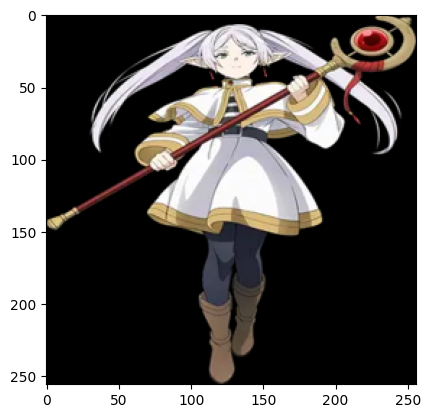

In [241]:
# read a png image
from PIL import Image
path = "Friern.png"
img = Image.open(path)
# reshape to 256x256
img = img.resize((256, 256))
# to tensor
img = TF.to_tensor(img)[None, :, :, :][:, :3, :, :]
# show the image
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0))

In [42]:
index = 3
text = batch["captions"][index]
print(text)

This is an Japanese Anime style image.  The image features a person with purple hair, possibly a young girl, lying on a bed. The person has green eyes, and their hair is styled in a unique manner. The scene appears to be a close-up of the person's face, with the bed occupying the background. The person's distinctive appearance and the cozy setting of the bed create a captivating and memorable scene.


In [304]:
text ="""This is a Japanese Anime style image. The character is a young gril has long green hair."""


In [ ]:
text_2 ="""This is a Japanese Anime style image. The character has long white hair and is holding a wand with a red jewel and gold accents. 
They are dressed in a white and gold outfit with a cloak, paired with dark pants and brown boots."""

04/24/2024 15:31:00 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


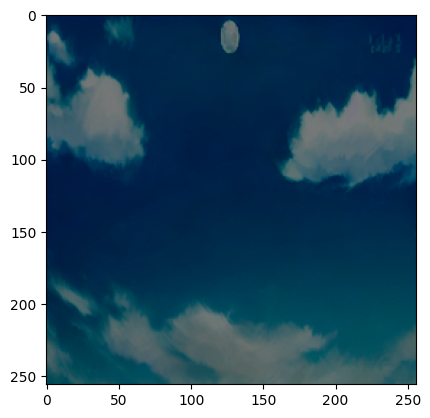

In [206]:
img1 = batch["conditioning_pixel_values"][0][None, :, :, :]
img2 = batch["conditioning_pixel_values_02"][3][None, :, :, :]
# show the image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(img1[0].detach().cpu().data.permute(1, 2, 0))

04/24/2024 16:08:26 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


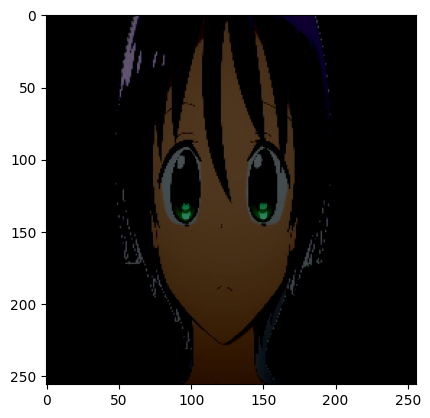

In [232]:
plt.imshow(img2[0].detach().cpu().data.permute(1, 2, 0))

In [305]:
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    args.pretrained_model_name_or_path,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    # controlnet=[controlnet, controlnet],
    safety_checker=None,
    revision=args.revision,
    variant=args.variant,
    torch_dtype=weight_dtype,
    cache_dir = HUGGING_FACE_CACHE_DIR,
)
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(accelerator.device)
pipeline.set_progress_bar_config(disable=True)


if args.enable_xformers_memory_efficient_attention:
    pipeline.enable_xformers_memory_efficient_attention()
    
if args.seed is None:
    generator = None
else:
    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

images = pipeline(
                    text,
                    # batch["scene_img"][i],
                    image=[img1, img], # inpainting_img, figure_img
                    # num_inference_steps=20,
                    num_inference_steps=50,
                    # num_inference_steps=1000,
                    generator=generator,
                    num_images_per_prompt=3,
                ).images

{'controlnet', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-1-base.
{'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-2-1-base.
{'lower_order_final', 'solver_p', 'use_karras_sigmas', 'disable_corrector', 'sample_max_value', 'thresholding', 'timestep_spacing', 'solver_type', 'solver_order', 'dynamic_thresholding_ratio', 'predict_x0'} was not found in config. Values will be initialized to default values.


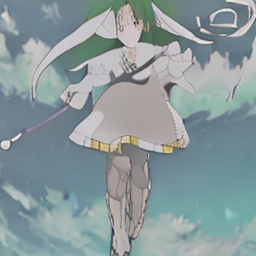

In [309]:
images[1]